In [42]:
# Import packages and set configuration
import pandas as pd
from IPython.display import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Asset list
Market Cap Ranking Comparison Based on Historical CoinMarketCap Snapshots.

In [43]:
# Load tickers
tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "TRXUSDT",
           "DOTUSDT", "LINKUSDT", "SHIBUSDT", "LTCUSDT", "BCHUSDT", "UNIUSDT"]
pd.read_excel('../data/asset_list.xlsm', dtype={'07.01.2024': 'Int64', '05.10.2025': 'Int64'}).iloc[:15, :2]

,Name,Symbol
0,Bitcoin,BTC
1,Ethereum,ETH
2,BNB,BNB
3,Solana,SOL
4,XRP,XRP
5,Cardano,ADA
6,Avalanche,AVAX
7,Dogecoin,DOGE
8,TRON,TRX
9,Polkadot,DOT


### Strategy 2: Cointegration Approach (Yang & Malik, 2024)
#### Pair selection
-  ##### 2024-01-01 - 2024-03-01 (2 months)
-  ##### Max Score from Correlation of Log Returns and Cointegration
#### Trading
-  ##### 2024-03-01 - 2024-04-01 (1 month)
-  ##### Spread = normPriceX - normPriceY
-  ##### Std From 6-Month Training (Const in Test Period)
-  ##### Entry Threshold: 2 * Std
-  ##### Exit Threshold: 0 (mean)

In [45]:
ps_start = "2024-01-01"
ps_end = "2024-03-01"

trading_start = "2024-03-01"
trading_end = "2024-04-01"

interval = "1h"

In [46]:
fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 1  # always 100% of portfolio
window_in_steps = 100

In [47]:
# Load data
from modules.data_services.data_pipeline import load_data

df = load_data(
    tickers=tickers,
    start=ps_start,
    end=ps_end,
    interval=interval
)

In [48]:
# Pair Selection
from modules.data_services.data_pipeline import merge_by_pair
from modules.pair_selection.statistical_tests import pearson_correlation, engle_granger_cointegration

corr_df = pearson_correlation(df, source='prices')
eg_df = engle_granger_cointegration(df)
merged_df = merge_by_pair(
    dfs=[corr_df, eg_df],
    keep_cols=[
        ['corr_prices'],
        ['eg_p_value']
    ]
)
merged_df['corr_prices * (1 - eg_p_value)'] = merged_df['corr_prices'] * (1 - merged_df['eg_p_value'])
merged_df.sort_values(by=['corr_prices * (1 - eg_p_value)'], ascending=False, inplace=True)
merged_df.reset_index(drop=True, inplace=True)
pairs_2 = merged_df.iloc[0:1, 0].tolist()
display(merged_df.head(5))

,pair,corr_prices,eg_p_value,corr_prices * (1 - eg_p_value)
0,BNBUSDT-UNIUSDT,0.884489,0.007593,0.877773
1,BTCUSDT-BCHUSDT,0.878947,0.004171,0.875281
2,ETHUSDT-BCHUSDT,0.850074,0.002988,0.847534
3,BTCUSDT-ADAUSDT,0.842703,0.013955,0.830942
4,BTCUSDT-SOLUSDT,0.834386,0.015325,0.821599


In [49]:
fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 1  # always 100% of portfolio

entry_threshold = 2 # 2 std from z-score
exit_threshold = 0.5
stop_loss = 1.5 #1.5 of an entry threshold; 150%
rolling_window = 100

In [50]:
# Load pair
from modules.data_services.data_pipeline import load_pair
from modules.data_services.data_utils import pre_training_start

pt_start = pre_training_start(start=trading_start, interval=interval, rolling_window_steps=rolling_window)

data = load_pair(x=pairs_2[0].split('-')[0], y=pairs_2[0].split('-')[1], start=pt_start, end=trading_end, interval=interval)

In [51]:
fee_rate = 0.0005  # 0.05%
initial_cash = 100000
position_size = 1  # always 100% of portfolio

entry_threshold = 2 # 2 std from z-score
exit_threshold = 0.5
stop_loss = 1.5 #1.5 of an entry threshold; 150%
rolling_window = 100

In [52]:
# Run strategy
from modules.performance.strategy_2 import run_strategy

data.fee_rate = fee_rate
data.initial_cash = initial_cash

run_strategy(data, entry_threshold, exit_threshold, stop_loss, position_size, rolling_window)
data.data

,BNBUSDT,UNIUSDT,z_score,spread,mean,std,beta,z_score_virtual,spread_virt,mean_pos,...,q_x,q_y,cash,signal,position,total_pnl,total_fees,net_pnl,total_pnl_pct,net_pnl_pct
open_time,,,,,,,,,,,,,,,,,,,,,
2024-02-25 00:00:00,381.5,11.543,None,None,None,None,None,None,None,None,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-25 01:00:00,380.6,11.384,None,None,None,None,None,None,None,None,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-25 02:00:00,380.3,10.726,None,None,None,None,None,None,None,None,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-25 03:00:00,379.5,10.451,None,None,None,None,None,None,None,None,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-25 04:00:00,378.7,10.522,None,None,None,None,None,None,None,None,...,0.000000,0.000000,1.000000e+05,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 20:00:00,606.9,13.022,-0.339442,-0.006096,0.0,0.01796,0.706443,2.299714,0.026888,0.0,...,-162.695493,48.099427,-1.455192e-11,0.0,-1.0,11052.169581,1852.922824,9199.246757,0.110522,0.091992
2024-03-31 21:00:00,606.1,12.945,-0.289194,-0.005082,0.0,0.017573,0.690164,2.336858,0.027322,0.0,...,-162.695493,48.099427,-1.455192e-11,0.0,-1.0,11186.029631,1852.922824,9333.106807,0.111860,0.093331
2024-03-31 22:00:00,605.8,12.906,-0.135173,-0.002318,-0.0,0.017147,0.673695,2.370809,0.027719,0.0,...,-162.695493,48.099427,-1.455192e-11,0.0,-1.0,11236.714156,1852.922824,9383.791332,0.112367,0.093838


In [53]:
# Calculate statistics
from modules.performance.strategy_2 import calculate_stats

data.stats = calculate_stats(data)
data.stats

,0% fee,0.05% fee
metric,,
total_return,0.112880,0.094351
volatility,0.003429,0.003469
max_drawdown,-0.064008,-0.066667
win_count,11.000000,11.000000
lose_count,9.000000,9.000000
win_rate,0.550000,0.550000
max_win,0.060684,0.060214
max_lose,-0.033569,-0.034086
avg_trade_return,0.005644,0.005218


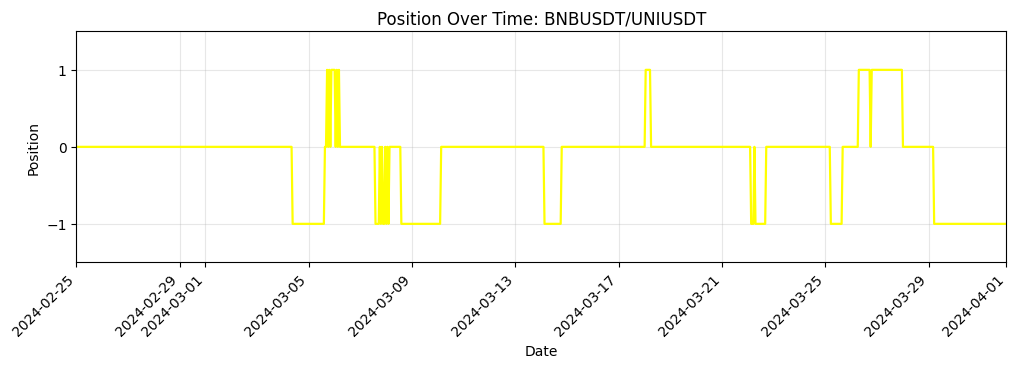

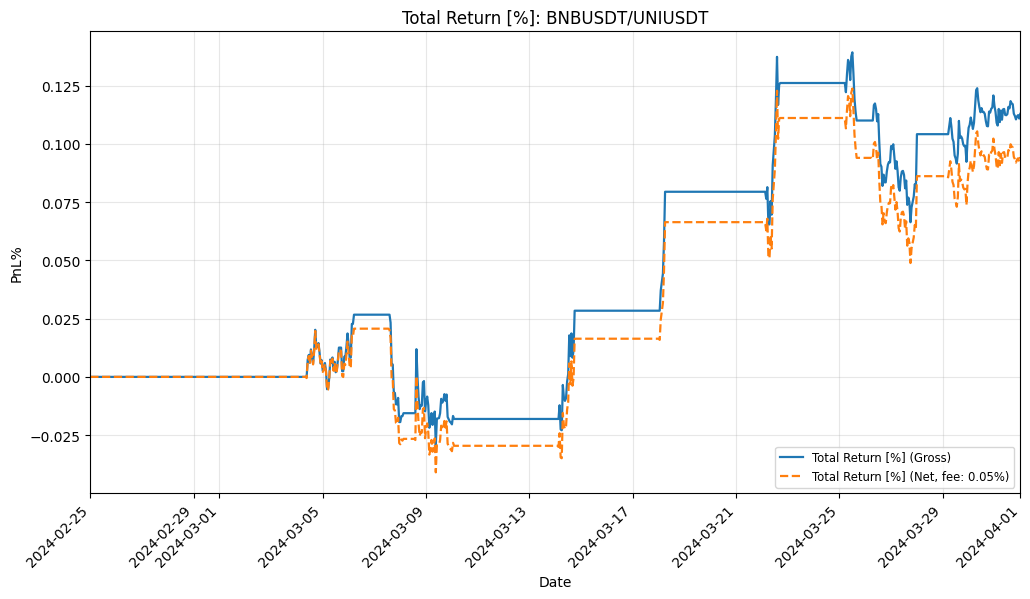

In [54]:
# Visualization
from modules.visualization.plots import plot_pnl, plot_positions

plot_positions(data, 'strategy_2', False, True)
plot_pnl(data, 'strategy_2', False, True)

Do zrobienia:
- dynamiczna wielkość pozycji (w tej chwili obsługuje tylko position_size=1)
- multi-asset i wiele pozycji jednocześnie

#### Najważniejsze cele:

- chcemy za pomocą RL optymalizować strategię MARKET NEUTRAL pair tradingu (domyślnie Cointegration Approach ulepszone o RL, ale warto zaimplementować również podejście oparte na Ornstein–Uhlenbeck process - do zrobienia)

Agent będzie dynamicznie (co krok) decydować o:
- entry/exit threshold
- stop loss
- position_size: wielkość pozycji (0,1] (0.8 -> 80% kapitału), również w trakcie pozycji (redukować je lub zwiększać, ale tylko po becie tej pozycji)

Dynamiczna wielkość pozycji:
- zamiast otwierania zawsze za 100% agent będzie decydować o wielkości pozycji aby zmniejszać ryzyko
- gdy zdecyduje o otwarciu pozycji 0.6 (60% kapitału w long leg po becie), to zostanie mu 40% kapitału na inne pozycje (jeśli będą kolejne sygnały przy innych betach na z-score); wtedy będzie mógł za max 40% otworzyć nową pozycję po nowej becie; będzie mógł również redukować istniejące pozycje (zmniejszać ich position_size, np. do 0 jeśli będzie chciał z niej wyjść) lub zwiększać ją (ale tylko po jej becie)

#### Jak sprawdzić skuteczność agenta w doborze parametrów do strategii?

Bez RL:
- bierzemy n okresów trening/test, robimy Bayesian Optimization na pierwszym (wyliczając dające największy score entry/exit thresholds, stop loss i rolling window) i robimy analizę wyniku strategii na tych parametrach w trakcie n okresów (w następnych okresach te poziomy nie będą już idealne)

RL:
- na początku agent nie wybierze najlepszych możliwych parametrów, ale w następnych oknach powinien mieć lepszą politykę, która będzie zwiększać jego skuteczność; naszym celem jest to, aby po n okresach wynik tej strategii był lepszy niż podejście bez RL (czyli z idealnymi parametrami dla pierwszego okresu)